# 패키지 로딩

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import warnings

warnings.filterwarnings("ignore")

# 함수 로딩

In [2]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i + target_size])
            
    return np.array(data), np.array(labels)

In [24]:
def plot_train_history(history, function):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))
    
    plt.rcParams['font.family'] ='Malgun Gothic'
    plt.figure(figsize=(12, 8))
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    
    plt.xlabel("Epoch")
    plt.ylabel(function)
    
    plt.title("모델 손실함수 시각화")
    plt.legend()
    plt.grid()

    plt.show()

# 전처리 데이터 불러오기

In [2]:
area_list = ["POI013", "POI014", "POI015", "POI017", "POI018", "POI019", "POI033", "POI034", "POI038", "POI039", "POI042", "POI043", "POI045", "POI046"]

data = pd.DataFrame()

for area in area_list:
    temp = pd.read_csv(f"{area} 전처리 데이터.csv")
    
    data = data.append(temp)
    
data = data.drop("Unnamed: 0", axis = 1).reset_index(drop=True)
data["cur_time"] = pd.to_datetime(data["cur_time"])

## 해 유무 라벨링

In [3]:
data["dt_date"] = data["cur_time"].dt.date
data["dt_date"] = data["dt_date"].astype(str)

data["sunrise_datetime"] = data["dt_date"] + " " + data["SUNRISE"]
data["sunrise_datetime"] = pd.to_datetime(data["sunrise_datetime"])

data["sunset_datetime"] = data["dt_date"] + " " + data["SUNSET"]
data["sunset_datetime"] = pd.to_datetime(data["sunset_datetime"])

data["is_sun"] = (data["cur_time"] >= data["sunrise_datetime"]) & (data["cur_time"] <= data["sunset_datetime"])

data["is_sun"] = data["is_sun"].astype(int)

data = data.drop(["SUNRISE", "SUNSET", "dt_date", "sunrise_datetime", "sunset_datetime"], axis = 1)

## 강수량

In [4]:
import re

data["PRECIPITATION"] = data["PRECIPITATION"].replace("-", "0")

pattern = r'[~]?(\d+\.\d+)'

def extract_float(text):
    match = re.search(pattern, str(text))
    if match:
        return float(match.group(1))
    else:
        return None

data['PRECIPITATION'] = data['PRECIPITATION'].apply(extract_float)
data["PRECIPITATION"] = data["PRECIPITATION"].fillna(0)

## 혼잡도 라벨링

In [5]:
label_dict = {'여유': 0, '보통': 1, '약간 붐빔': 2, '붐빔': 3}

# 라벨링
data['AREA_CONGEST_LVL'] = data['AREA_CONGEST_LVL'].map(label_dict)

## 휴일 주말 라벨링

In [6]:
data['is_weekend'] = data['cur_time'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)

data['is_holiday'] = (data['cur_time'].dt.month == 4) & (data['cur_time'].dt.day == 10)
data['is_holiday'] = data['is_holiday'].astype(int)

data['is_holiday_or_weekend'] = data['is_holiday'] | data['is_weekend']

data = data.drop(["is_holiday", "is_weekend"], axis = 1)

In [7]:
data = data.rename(columns={"cur_time":"date"})

# 변수 상관관계 분석

In [8]:
import seaborn as sns
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [9]:
temp = data[data["sbike_spot_id"] == "ST-1140"].iloc[:,3:-2]

In [10]:
temp.to_csv("ST_1140.csv", index=False, encoding="utf-8-sig")

In [11]:
temp.columns

Index(['sbike_parking_cnt', 'TEMP', 'SENSIBLE_TEMP', 'HUMIDITY', 'WIND_SPD',
       'PRECIPITATION', 'UV_INDEX_LVL', 'PM25', 'PM10', 'AIR_IDX_MVL',
       'AREA_CONGEST_LVL', 'AREA_PPLTN_MIN', 'AREA_PPLTN_MAX',
       'MALE_PPLTN_RATE', 'FEMALE_PPLTN_RATE', 'PPLTN_RATE_0', 'PPLTN_RATE_10',
       'PPLTN_RATE_20', 'PPLTN_RATE_30', 'PPLTN_RATE_40', 'PPLTN_RATE_50',
       'PPLTN_RATE_60', 'PPLTN_RATE_70', 'RESNT_PPLTN_RATE',
       'NON_RESNT_PPLTN_RATE'],
      dtype='object')

In [12]:
temp

,sbike_parking_cnt,TEMP,SENSIBLE_TEMP,HUMIDITY,WIND_SPD,PRECIPITATION,UV_INDEX_LVL,PM25,PM10,AIR_IDX_MVL,...,PPLTN_RATE_0,PPLTN_RATE_10,PPLTN_RATE_20,PPLTN_RATE_30,PPLTN_RATE_40,PPLTN_RATE_50,PPLTN_RATE_60,PPLTN_RATE_70,RESNT_PPLTN_RATE,NON_RESNT_PPLTN_RATE
0,5.0,13.2,13.2,29.0,1.7,0.0,0.0,13.0,39.0,68.0,...,0.3,4.2,22.1,24.3,18.5,15.5,9.4,5.6,50.1,49.9
12,5.0,13.2,13.2,29.0,1.7,0.0,0.0,13.0,39.0,68.0,...,0.3,4.2,22.1,24.3,18.5,15.5,9.4,5.6,50.1,49.9
24,5.0,13.2,13.2,29.0,1.7,0.0,0.0,13.0,39.0,68.0,...,0.3,4.2,22.1,24.3,18.5,15.5,9.4,5.6,50.1,49.9
36,5.0,13.2,13.2,29.0,1.7,0.0,0.0,13.0,39.0,68.0,...,0.3,4.2,22.1,24.3,18.5,15.5,9.4,5.6,50.1,49.9
48,5.0,13.2,13.2,29.0,1.7,0.0,0.0,13.0,39.0,68.0,...,0.3,4.2,22.1,24.3,18.5,15.5,9.4,5.6,50.1,49.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362820,8.0,20.2,20.2,59.0,0.1,0.0,0.0,39.0,66.0,86.0,...,0.3,3.4,22.1,23.3,18.5,16.4,10.5,5.4,39.7,60.3
362832,8.0,20.2,20.2,59.0,0.1,0.0,0.0,39.0,66.0,86.0,...,0.3,3.4,22.1,23.3,18.5,16.4,10.5,5.4,39.7,60.3
362844,8.0,20.2,20.2,59.0,0.1,0.0,0.0,39.0,66.0,86.0,...,0.3,3.4,22.1,23.3,18.5,16.4,10.5,5.4,39.7,60.3
362856,8.0,20.2,20.2,59.0,0.1,0.0,0.0,39.0,66.0,86.0,...,0.3,3.4,22.1,23.3,18.5,16.4,10.5,5.4,39.7,60.3


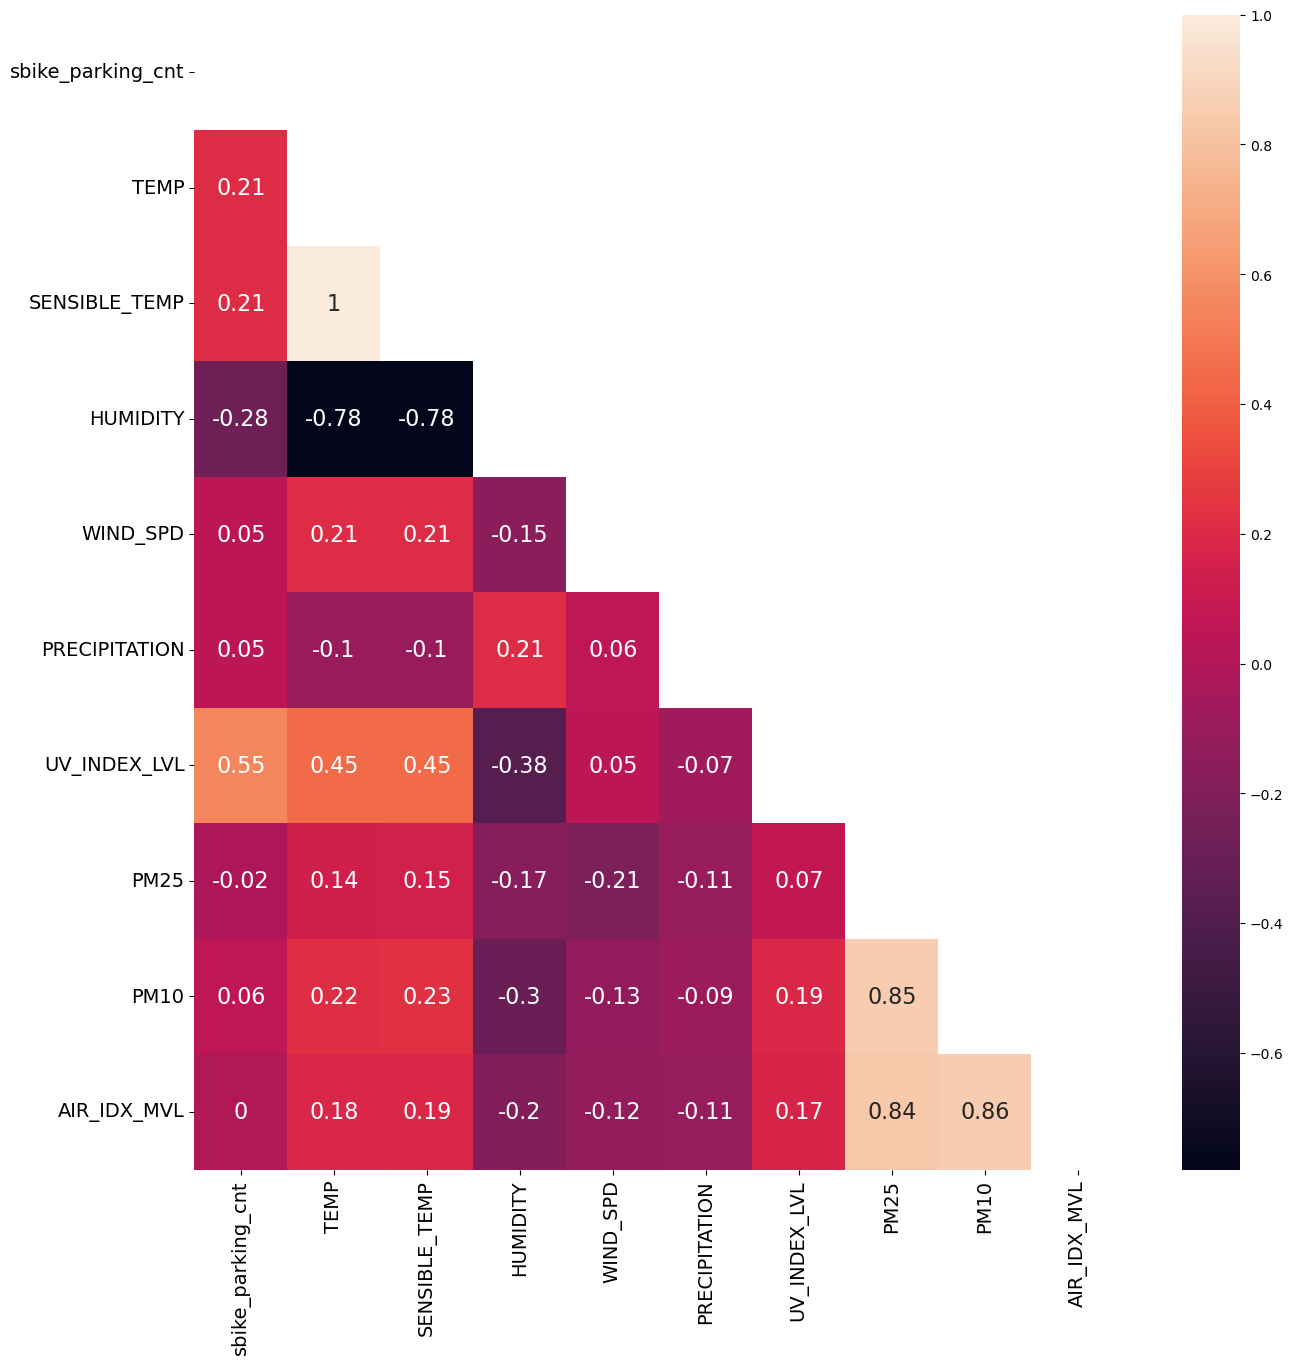

In [20]:
weather_corr = temp[['sbike_parking_cnt', 'TEMP', 'SENSIBLE_TEMP', 'HUMIDITY', 'WIND_SPD',
       'PRECIPITATION', 'UV_INDEX_LVL', 'PM25', 'PM10', 'AIR_IDX_MVL']].corr()

fig, ax = plt.subplots(1, 1, figsize = (15, 15))

weather_corr = round(weather_corr, 2)
mask_feature = np.triu(np.ones_like(weather_corr, dtype=bool))

sns.heatmap(weather_corr, 
            mask = mask_feature,
            annot=True,
            annot_kws={"size": 16})

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")

# ax.hlines(range(weather_corr.shape[1]), *ax.get_xlim(), color = 'black')
# ax.vlines(range(weather_corr.shape[1]), *ax.get_ylim(), color = 'black')

plt.show()

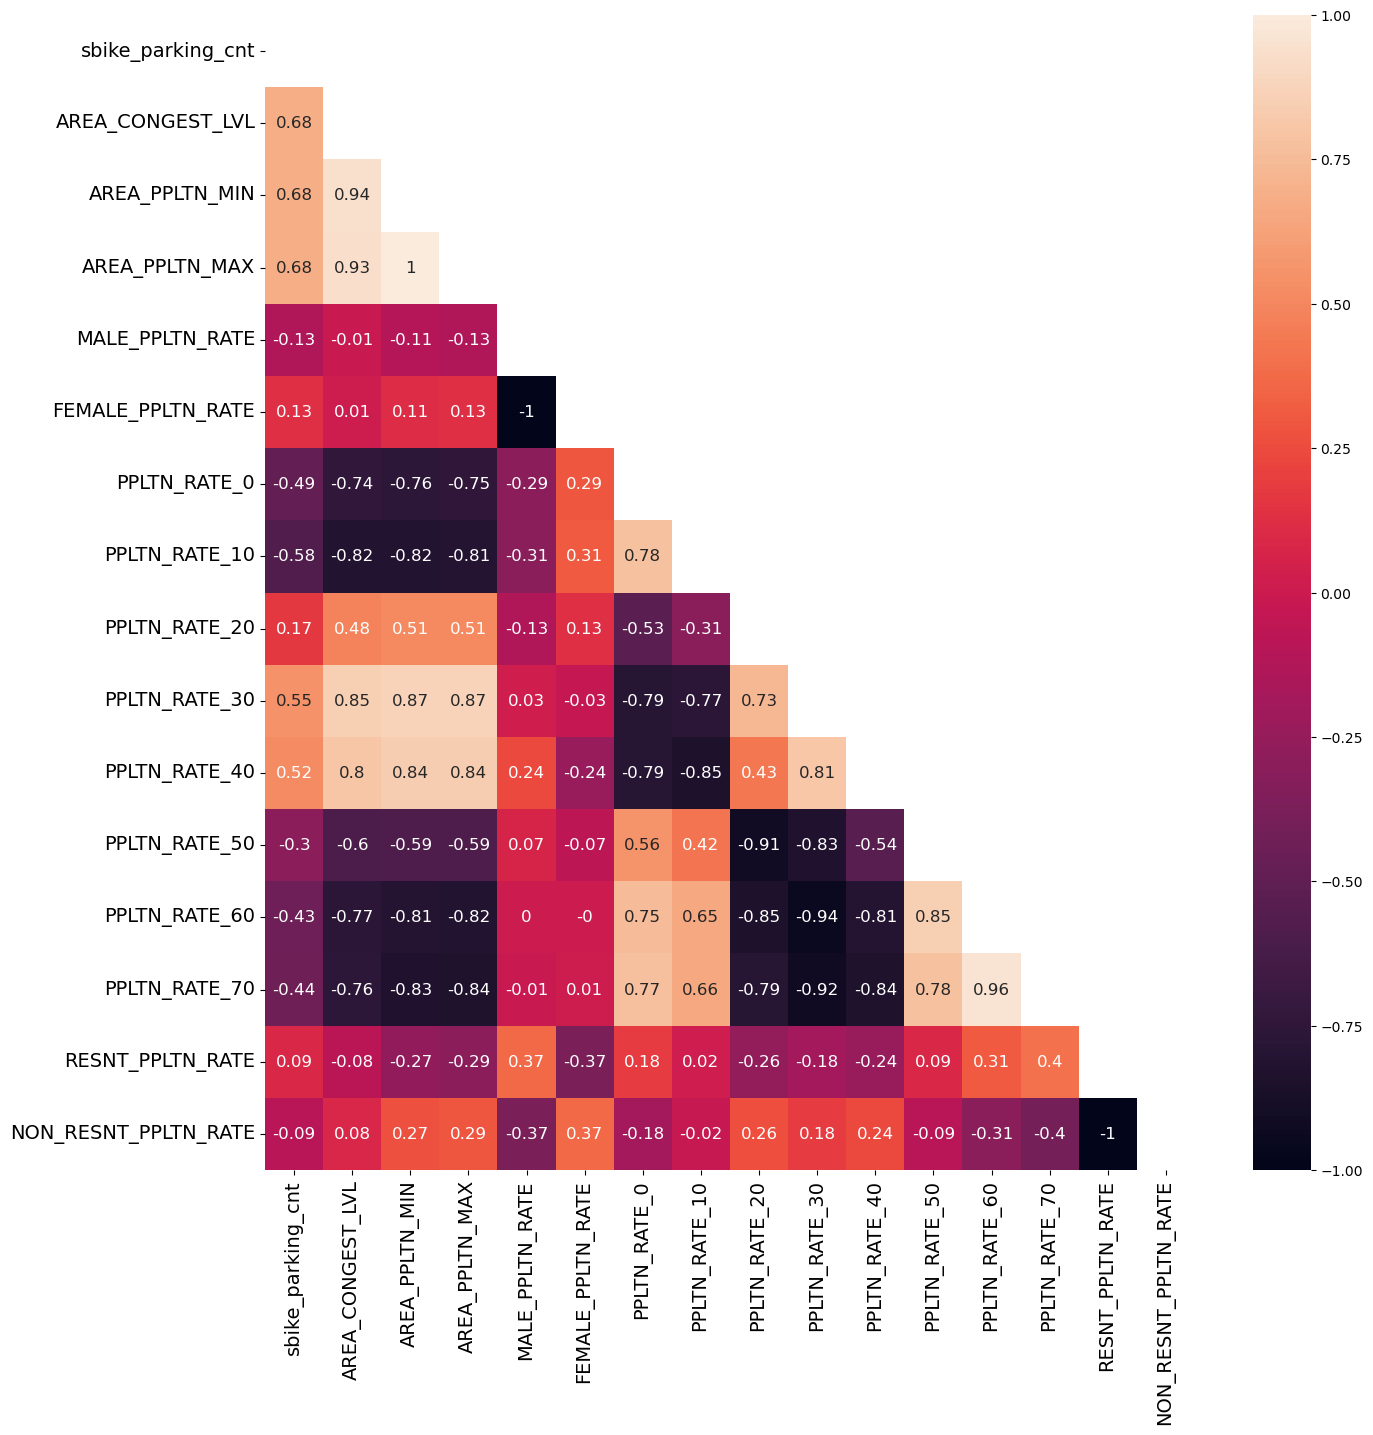

In [23]:
ppl_corr = temp[['sbike_parking_cnt', 'AREA_CONGEST_LVL', 'AREA_PPLTN_MIN', 'AREA_PPLTN_MAX',
       'MALE_PPLTN_RATE', 'FEMALE_PPLTN_RATE', 'PPLTN_RATE_0', 'PPLTN_RATE_10',
       'PPLTN_RATE_20', 'PPLTN_RATE_30', 'PPLTN_RATE_40', 'PPLTN_RATE_50',
       'PPLTN_RATE_60', 'PPLTN_RATE_70', 'RESNT_PPLTN_RATE',
       'NON_RESNT_PPLTN_RATE']].corr()

fig, ax = plt.subplots(1, 1, figsize = (15, 15))

ppl_corr = round(ppl_corr, 2)
mask_feature = np.triu(np.ones_like(ppl_corr, dtype=bool))

sns.heatmap(ppl_corr, 
            mask = mask_feature,
            annot=True,
            annot_kws={"size": 12})

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")


# ax.hlines(range(ppl_corr.shape[1]), *ax.get_xlim(), color = 'black')
# ax.vlines(range(ppl_corr.shape[1]), *ax.get_ylim(), color = 'black')

plt.show()

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

target = 'sbike_parking_cnt'
features = temp.columns.drop(target)

X = temp[features]
y = temp[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

importance_df = pd.DataFrame({'Feature': features[indices], 'Importance': importances[indices]})

print("변수 중요도:")
print(importance_df)

변수 중요도:
                 Feature  Importance
0         AREA_PPLTN_MIN    0.244259
1         AREA_PPLTN_MAX    0.233606
2          PPLTN_RATE_10    0.147386
3           UV_INDEX_LVL    0.121937
4            AIR_IDX_MVL    0.049790
5               HUMIDITY    0.037089
6                   PM10    0.016740
7       RESNT_PPLTN_RATE    0.016239
8               WIND_SPD    0.016113
9   NON_RESNT_PPLTN_RATE    0.015082
10         PPLTN_RATE_20    0.014857
11         PPLTN_RATE_40    0.011805
12                  PM25    0.011729
13                  TEMP    0.010214
14         SENSIBLE_TEMP    0.009865
15       MALE_PPLTN_RATE    0.008067
16         PPLTN_RATE_70    0.007479
17     FEMALE_PPLTN_RATE    0.007319
18         PPLTN_RATE_50    0.006526
19         PPLTN_RATE_30    0.006051
20         PPLTN_RATE_60    0.004513
21         PRECIPITATION    0.001398
22          PPLTN_RATE_0    0.001244
23      AREA_CONGEST_LVL    0.000694


# LSTM 모델

## 정류소별 모델 구성

### 데이터 전처리
- 범주형: AREA_CONGEST_LVL, is_sun, is_holiday_or_weekend

In [8]:
ST_1140 = data[data["sbike_spot_id"] == "ST-1140"].reset_index(drop=True)
ST_1140 = ST_1140.drop(["date", "area_cd", "sbike_spot_id"], axis = 1)

In [9]:
dummies = pd.get_dummies(ST_1140["AREA_CONGEST_LVL"])
temp = ST_1140.drop('AREA_CONGEST_LVL', axis = 1)
temp = pd.concat([temp, dummies], axis = 1)

In [10]:
dataset = temp.values

standard = dataset[:, :-6]
remain = dataset[:, -6:]

data_mean = standard.mean(axis=0)
data_std = standard.std(axis=0)
standard = (standard-data_mean)/data_std

dataset = np.concatenate((standard, remain), axis=1)

In [11]:
sbike_mean = data_mean[0]
sbike_std = data_std[0]

### 모델 구성

In [14]:
# 하이퍼 파라매터 세팅
TRAIN_SPLIT = 17 * 24 * 60
TEST_SPLIT = 3 * 24 * 60

# 32, 64, 128, 256
BATCH_SIZE = 256
EPOCHS = 120

# 60분 학습 - 10분 예측
past_history = 60
future_target = 10
STEP = 1

tf.random.set_seed(13)

In [15]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0, TRAIN_SPLIT, past_history, future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0], TRAIN_SPLIT, TRAIN_SPLIT + TEST_SPLIT, past_history, future_target, STEP)

x_test_multi, y_test_multi = multivariate_data(dataset, dataset[:, 0], TRAIN_SPLIT + TEST_SPLIT, None, past_history, future_target, STEP)

print(x_train_multi.shape)
print('Single window of past history : {}'.format(x_train_multi[0].shape))
print('Target time to predict : {}'.format(y_train_multi[0].shape))

print(x_val_multi.shape)

print(x_test_multi.shape)

(24420, 60, 30)
Single window of past history : (60, 30)
Target time to predict : (10,)
(4260, 60, 30)
(1370, 60, 30)


In [16]:
BUFFER_SIZE = 100

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))

train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [17]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# 학습률 감소
# def lr_scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)

# lr_scheduler = LearningRateScheduler(lr_scheduler, verbose=1)    
    
initial_lr = 0.001
optimizer = RMSprop(learning_rate=initial_lr, clipvalue=1.0)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

multi_step_model = Sequential()

multi_step_model.add(LSTM(32, return_sequences=True, input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(Dropout(0.2))
multi_step_model.add(LSTM(16, activation='relu'))
multi_step_model.add(Dropout(0.2))
multi_step_model.add(Dense(10))

multi_step_model.compile(optimizer=optimizer, loss='mae')

multi_step_history = multi_step_model.fit(
    train_data_multi, 
    epochs = EPOCHS, 
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_data = val_data_multi, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[
#         lr_scheduler, 
        lr_restart, 
        early_stop
    ])

plot_train_history(multi_step_history)

Epoch 1/120
95/95 [==============================] - 9s 74ms/step - loss: 0.6809 - val_loss: 0.7726 - lr: 0.0010
Epoch 2/120
95/95 [==============================] - 6s 63ms/step - loss: 0.4899 - val_loss: 0.6319 - lr: 0.0010
Epoch 3/120
95/95 [==============================] - 6s 65ms/step - loss: 0.3741 - val_loss: 0.5405 - lr: 0.0010
Epoch 4/120
95/95 [==============================] - 6s 65ms/step - loss: 0.2985 - val_loss: 0.4288 - lr: 0.0010
Epoch 5/120
95/95 [==============================] - 6s 66ms/step - loss: 0.2596 - val_loss: 0.3979 - lr: 0.0010
Epoch 6/120
95/95 [==============================] - 6s 67ms/step - loss: 0.2365 - val_loss: 0.3694 - lr: 0.0010
Epoch 7/120
95/95 [==============================] - 7s 69ms/step - loss: 0.2180 - val_loss: 0.3378 - lr: 0.0010
Epoch 8/120
95/95 [==============================] - 7s 69ms/step - loss: 0.2069 - val_loss: 0.3585 - lr: 0.0010
Epoch 9/120
95/95 [==============================] - 7s 70ms/step - loss: 0.1975 - val_loss: 0.2

KeyboardInterrupt: 

### 모델 저장

In [ ]:
predict = multi_step_model.predict(x_test_multi)

In [ ]:
y_test_multi.shape

In [ ]:
# 1440분 - 60분(학습 window) - 10분(예측 기간)
## (1시 00분 ~ 1시 10분), (1시 01분 ~ 1시 11분), ... , (23시 50분 ~ 23시 59분)
predict.shape

In [ ]:
# 1시 ~ 2시: 0 ~ 59(60개)
# 2시 ~ 3시: 60 ~ 119(60개)

hour = 15
minute = 30
time = (hour - 1) * 60 + minute

y_hat = predict[time]
y_hat = y_hat * sbike_std + sbike_mean
print(y_hat)

y = y_test_multi[time]
y = y * sbike_std + sbike_mean
print(y)

In [ ]:
multi_step_model.save('ST_1140.h5')

## 통합 모델 구성
- 대여소 ID 단위로 무작위로 학습 데이터 추출

In [3]:
area_list = ["POI013", "POI014", "POI015", "POI017", "POI018", "POI019", "POI033", "POI034", "POI038", "POI039", "POI042", "POI043", "POI045", "POI046"]

data = pd.DataFrame()

for area in area_list:
    temp = pd.read_csv(f"{area} 전처리 데이터.csv")
    
    data = data.append(temp)
    
data = data.drop("Unnamed: 0", axis = 1).reset_index(drop=True)
data["cur_time"] = pd.to_datetime(data["cur_time"])

data["dt_date"] = data["cur_time"].dt.date
data["dt_date"] = data["dt_date"].astype(str)

data["sunrise_datetime"] = data["dt_date"] + " " + data["SUNRISE"]
data["sunrise_datetime"] = pd.to_datetime(data["sunrise_datetime"])

data["sunset_datetime"] = data["dt_date"] + " " + data["SUNSET"]
data["sunset_datetime"] = pd.to_datetime(data["sunset_datetime"])

data["is_sun"] = (data["cur_time"] >= data["sunrise_datetime"]) & (data["cur_time"] <= data["sunset_datetime"])

data["is_sun"] = data["is_sun"].astype(int)

data = data.drop(["SUNRISE", "SUNSET", "dt_date", "sunrise_datetime", "sunset_datetime"], axis = 1)

import re

data["PRECIPITATION"] = data["PRECIPITATION"].replace("-", "0")

pattern = r'[~]?(\d+\.\d+)'

def extract_float(text):
    match = re.search(pattern, str(text))
    if match:
        return float(match.group(1))
    else:
        return None

data['PRECIPITATION'] = data['PRECIPITATION'].apply(extract_float)
data["PRECIPITATION"] = data["PRECIPITATION"].fillna(0)

label_dict = {'여유': 0, '보통': 1, '약간 붐빔': 2, '붐빔': 3}

# 라벨링
data['AREA_CONGEST_LVL'] = data['AREA_CONGEST_LVL'].map(label_dict)

data['is_weekend'] = data['cur_time'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)

data['is_holiday'] = (data['cur_time'].dt.month == 4) & (data['cur_time'].dt.day == 10)
data['is_holiday'] = data['is_holiday'].astype(int)

data['is_holiday_or_weekend'] = data['is_holiday'] | data['is_weekend']

data = data.drop(["is_holiday", "is_weekend"], axis = 1)

data = data.rename(columns={"cur_time":"date"})

area_spot_dict = {}

for area in data["area_cd"].unique():
    area_spot_dict[area] = list(data[data["area_cd"] == area]["sbike_spot_id"].unique())
    
station_ids = data['sbike_spot_id'].unique()
station_id_mapping = {idx: station_id for idx, station_id in enumerate(station_ids)}

dummies = pd.get_dummies(data["AREA_CONGEST_LVL"])
data = data.drop('AREA_CONGEST_LVL', axis = 1)
data = pd.concat([data, dummies], axis = 1)

### one-hot encoding

In [4]:
dummies = pd.get_dummies(data["sbike_spot_id"])
data = data.drop(['date','area_cd'], axis = 1)

In [5]:
dataset = data.iloc[:, 1:25].values

data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

dts_std = pd.DataFrame(dataset, columns=['sbike_parking_cnt',
                        'TEMP',         'SENSIBLE_TEMP',
                    'HUMIDITY',              'WIND_SPD',
               'PRECIPITATION',          'UV_INDEX_LVL',
                        'PM25',                  'PM10',
                 'AIR_IDX_MVL',        'AREA_PPLTN_MIN',
              'AREA_PPLTN_MAX',       'MALE_PPLTN_RATE',
           'FEMALE_PPLTN_RATE',          'PPLTN_RATE_0',
               'PPLTN_RATE_10',         'PPLTN_RATE_20',
               'PPLTN_RATE_30',         'PPLTN_RATE_40',
               'PPLTN_RATE_50',         'PPLTN_RATE_60',
               'PPLTN_RATE_70',      'RESNT_PPLTN_RATE',
        'NON_RESNT_PPLTN_RATE'])

In [6]:
sbike_mean = data_mean[0]

In [7]:
sbike_std = data_std[0]

In [8]:
data = pd.concat([data[["sbike_spot_id"]], dts_std, data[[ 'is_sun', 'is_holiday_or_weekend',0,1,2,3]], dummies], axis = 1)

In [9]:
import gc

del dummies

gc.collect()

43

In [11]:
import gc

num_stations = 54
num_data = 30240

window_size = 60
prediction_size = 10

X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

In [12]:
for _ in range(2500):
    station_idx = np.random.randint(num_stations)
    station_id = station_id_mapping[station_idx]
    
    start_idx = np.random.randint(num_data - window_size - prediction_size)
    end_idx = start_idx + window_size

    dataset = data[data["sbike_spot_id"] == station_id].drop("sbike_spot_id", axis = 1).values
    
    X_sample = dataset[start_idx : end_idx]
    y_sample = dataset[end_idx:end_idx+prediction_size, 0]
    
    X_train.append(X_sample)
    y_train.append(y_sample)
    
    del X_sample
    del y_sample
    
    gc.collect()
    
X_train = np.array(X_train)
y_train = np.array(y_train)

In [13]:
for _ in range(625):
    station_idx = np.random.randint(num_stations)
    station_id = station_id_mapping[station_idx]
    
    start_idx = np.random.randint(num_data - window_size - prediction_size)
    end_idx = start_idx + window_size

    dataset = data[data["sbike_spot_id"] == station_id].drop("sbike_spot_id", axis = 1).values
    
    X_sample = dataset[start_idx : end_idx]
    y_sample = dataset[end_idx:end_idx+prediction_size, 0]
    
    X_val.append(X_sample)
    y_val.append(y_sample)
    
    del X_sample
    del y_sample
    
    gc.collect()
    
X_val = np.array(X_val)
y_val = np.array(y_val)

In [32]:
BATCH_SIZE = 256
EPOCHS = 500

BUFFER_SIZE = 100

tf.random.set_seed(13)

train_data_multi = tf.data.Dataset.from_tensor_slices((X_train, y_train))

train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Epoch 1/500
2/2 [==============================] - 3s 601ms/step - loss: 20.2911 - val_loss: 19.3874 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 232ms/step - loss: 19.0952 - val_loss: 18.5510 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 222ms/step - loss: 18.2886 - val_loss: 17.8726 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 228ms/step - loss: 17.6481 - val_loss: 17.2792 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 209ms/step - loss: 17.1308 - val_loss: 16.7391 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 232ms/step - loss: 16.5738 - val_loss: 16.2367 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 226ms/step - loss: 16.0525 - val_loss: 15.7629 - lr: 0.0010
Epoch 8/500
2/2 [==============================] - 0s 231ms/step - loss: 15.5456 - val_loss: 15.3107 - lr: 0.0010
Epoch 9/500
2/2 [==============================] - 0s 231ms/step - loss: 15.1211 - val_l

2/2 [==============================] - 0s 220ms/step - loss: 2.1903 - val_loss: 2.1776 - lr: 0.0010
Epoch 74/500
2/2 [==============================] - 0s 224ms/step - loss: 2.1780 - val_loss: 2.1102 - lr: 0.0010
Epoch 75/500
2/2 [==============================] - 0s 199ms/step - loss: 2.1755 - val_loss: 2.1548 - lr: 0.0010
Epoch 76/500
2/2 [==============================] - 0s 234ms/step - loss: 2.1469 - val_loss: 2.0668 - lr: 0.0010
Epoch 77/500
2/2 [==============================] - 0s 234ms/step - loss: 2.0601 - val_loss: 2.0122 - lr: 0.0010
Epoch 78/500
2/2 [==============================] - 0s 245ms/step - loss: 2.0411 - val_loss: 2.0408 - lr: 0.0010
Epoch 79/500
2/2 [==============================] - 0s 241ms/step - loss: 2.0414 - val_loss: 2.0466 - lr: 0.0010
Epoch 80/500
2/2 [==============================] - 0s 206ms/step - loss: 2.0486 - val_loss: 1.9344 - lr: 0.0010
Epoch 81/500
2/2 [==============================] - 0s 235ms/step - loss: 2.0076 - val_loss: 1.9962 - lr: 0.0

2/2 [==============================] - 0s 233ms/step - loss: 1.3677 - val_loss: 1.3553 - lr: 5.0000e-04
Epoch 144/500
2/2 [==============================] - 0s 231ms/step - loss: 1.3517 - val_loss: 1.2881 - lr: 5.0000e-04
Epoch 145/500
2/2 [==============================] - 0s 192ms/step - loss: 1.3679 - val_loss: 1.2777 - lr: 5.0000e-04
Epoch 146/500
2/2 [==============================] - 0s 230ms/step - loss: 1.3725 - val_loss: 1.2948 - lr: 5.0000e-04
Epoch 147/500
2/2 [==============================] - 0s 225ms/step - loss: 1.3359 - val_loss: 1.2851 - lr: 5.0000e-04
Epoch 148/500
2/2 [==============================] - 0s 232ms/step - loss: 1.3104 - val_loss: 1.2579 - lr: 5.0000e-04
Epoch 149/500
2/2 [==============================] - 0s 226ms/step - loss: 1.3303 - val_loss: 1.2751 - lr: 5.0000e-04
Epoch 150/500
2/2 [==============================] - 0s 200ms/step - loss: 1.3475 - val_loss: 1.2661 - lr: 5.0000e-04
Epoch 151/500
2/2 [==============================] - 0s 230ms/step - l

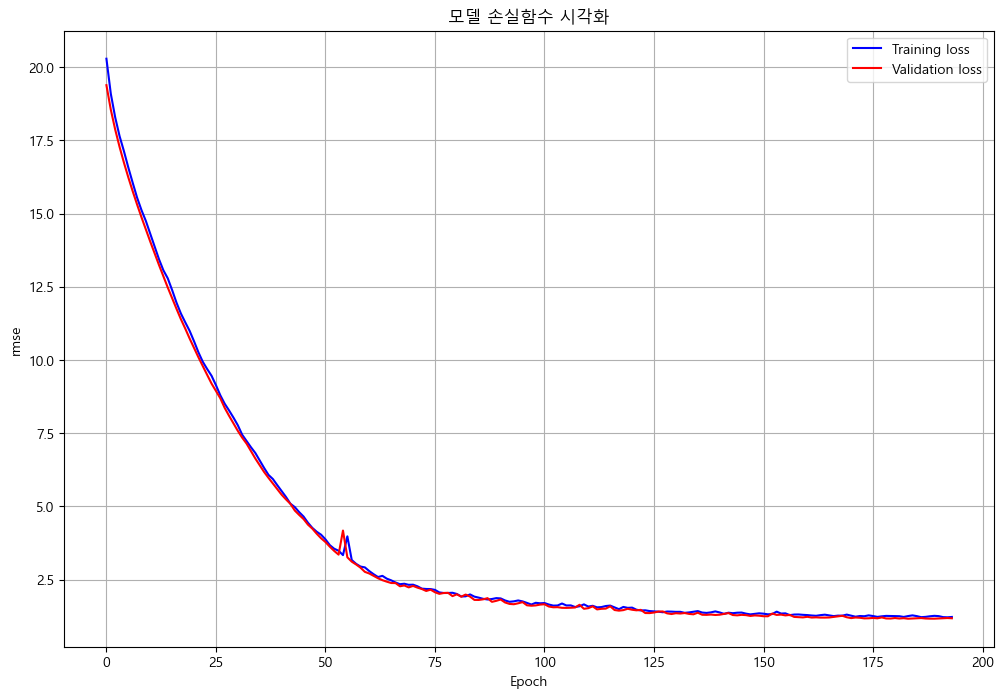

In [33]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.losses import mean_squared_error
import tensorflow.keras.backend as K

def rmse(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

initial_lr = 0.001
optimizer = RMSprop(learning_rate=initial_lr, clipvalue=1.0)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

multi_step_model = Sequential()

multi_step_model.add(LSTM(48, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.01, l2=0.01),
                          bias_regularizer=l1_l2(l1=0.01, l2=0.01),
                          input_shape=X_train.shape[-2:]))
multi_step_model.add(Dropout(0.3))
multi_step_model.add(LSTM(24, activation='relu',
                          kernel_regularizer=l1_l2(l1=0.01, l2=0.01),
                          bias_regularizer=l1_l2(l1=0.01, l2=0.01)))
multi_step_model.add(Dropout(0.3))
multi_step_model.add(Dense(10))

multi_step_model.compile(optimizer=optimizer, loss=rmse)

multi_step_history = multi_step_model.fit(
    train_data_multi, 
    epochs = EPOCHS, 
    steps_per_epoch = X_val.shape[0] // BATCH_SIZE, 
    validation_data = val_data_multi, 
    validation_steps = y_val.shape[0] // BATCH_SIZE,
    callbacks=[lr_restart, early_stop])

plot_train_history(multi_step_history, "rmse")

Epoch 1/500
2/2 [==============================] - 3s 681ms/step - loss: 20.1615 - val_loss: 19.2808 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 1s 331ms/step - loss: 18.9703 - val_loss: 18.4466 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 317ms/step - loss: 18.1740 - val_loss: 17.7683 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 310ms/step - loss: 17.5151 - val_loss: 17.1753 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 275ms/step - loss: 17.0404 - val_loss: 16.6352 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 328ms/step - loss: 16.4850 - val_loss: 16.1306 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 319ms/step - loss: 15.8791 - val_loss: 15.6528 - lr: 0.0010
Epoch 8/500
2/2 [==============================] - 0s 306ms/step - loss: 15.4517 - val_loss: 15.1988 - lr: 0.0010
Epoch 9/500
2/2 [==============================] - 0s 317ms/step - loss: 15.0306 - val_l

2/2 [==============================] - 0s 306ms/step - loss: 2.1669 - val_loss: 2.0782 - lr: 0.0010
Epoch 74/500
2/2 [==============================] - 0s 302ms/step - loss: 2.1321 - val_loss: 2.0878 - lr: 0.0010
Epoch 75/500
2/2 [==============================] - 0s 282ms/step - loss: 2.1916 - val_loss: 2.0269 - lr: 0.0010
Epoch 76/500
2/2 [==============================] - 0s 313ms/step - loss: 2.0779 - val_loss: 2.0098 - lr: 0.0010
Epoch 77/500
2/2 [==============================] - 0s 325ms/step - loss: 2.0457 - val_loss: 2.0625 - lr: 0.0010
Epoch 78/500
2/2 [==============================] - 0s 311ms/step - loss: 2.0469 - val_loss: 1.9221 - lr: 0.0010
Epoch 79/500
2/2 [==============================] - 0s 302ms/step - loss: 2.0236 - val_loss: 1.8918 - lr: 0.0010
Epoch 80/500
2/2 [==============================] - 0s 278ms/step - loss: 2.0321 - val_loss: 1.9103 - lr: 0.0010
Epoch 81/500
2/2 [==============================] - 0s 306ms/step - loss: 1.9642 - val_loss: 1.9619 - lr: 0.0

2/2 [==============================] - 0s 310ms/step - loss: 1.4314 - val_loss: 1.3536 - lr: 5.0000e-04
Epoch 143/500
2/2 [==============================] - 0s 318ms/step - loss: 1.4226 - val_loss: 1.3536 - lr: 5.0000e-04
Epoch 144/500
2/2 [==============================] - 0s 312ms/step - loss: 1.4445 - val_loss: 1.3519 - lr: 5.0000e-04
Epoch 145/500
2/2 [==============================] - 0s 262ms/step - loss: 1.4642 - val_loss: 1.3635 - lr: 5.0000e-04
Epoch 146/500
2/2 [==============================] - 0s 307ms/step - loss: 1.4268 - val_loss: 1.3788 - lr: 5.0000e-04
Epoch 147/500
2/2 [==============================] - 0s 314ms/step - loss: 1.4396 - val_loss: 1.3521 - lr: 5.0000e-04
Epoch 148/500
2/2 [==============================] - 0s 312ms/step - loss: 1.4370 - val_loss: 1.4576 - lr: 5.0000e-04
Epoch 149/500
2/2 [==============================] - ETA: 0s - loss: 1.4407
Epoch 149: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2/2 [=============================

Epoch 207/500
2/2 [==============================] - 0s 312ms/step - loss: 1.3117 - val_loss: 1.2420 - lr: 3.1250e-05
Epoch 208/500
2/2 [==============================] - 0s 318ms/step - loss: 1.2798 - val_loss: 1.2455 - lr: 3.1250e-05
Epoch 209/500
2/2 [==============================] - 0s 309ms/step - loss: 1.2949 - val_loss: 1.2508 - lr: 3.1250e-05
Epoch 210/500
2/2 [==============================] - 0s 264ms/step - loss: 1.3165 - val_loss: 1.2476 - lr: 3.1250e-05
Epoch 211/500
2/2 [==============================] - ETA: 0s - loss: 1.2983
Epoch 211: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
2/2 [==============================] - 0s 311ms/step - loss: 1.2983 - val_loss: 1.2564 - lr: 3.1250e-05


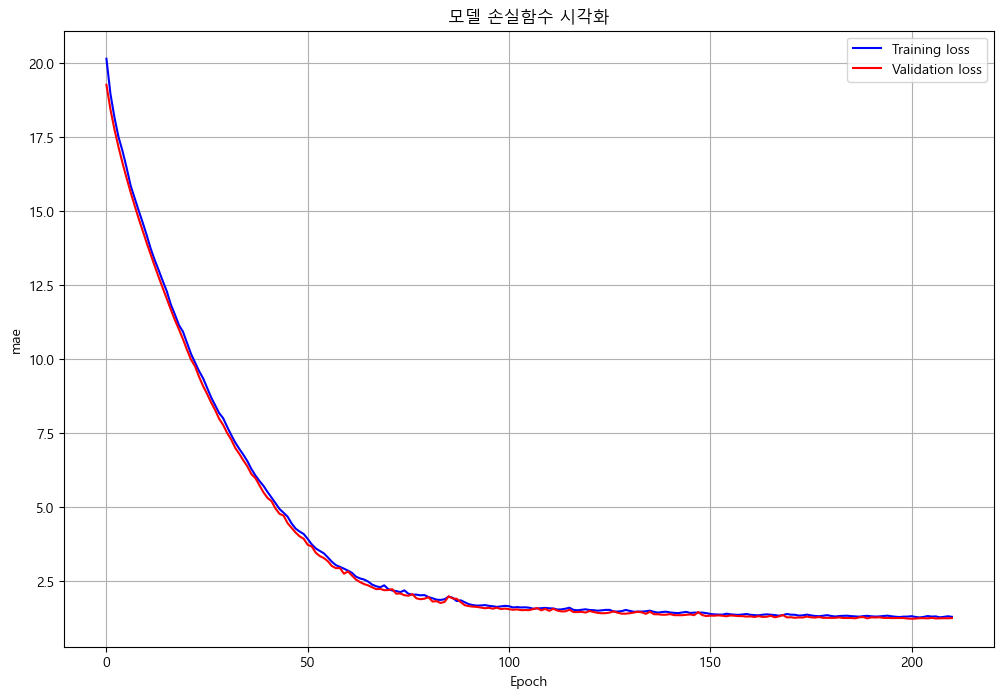

In [36]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l1_l2
# from tensorflow.keras.losses import mean_squared_error
# import tensorflow.keras.backend as K

# def rmse(y_true, y_pred):
#     return K.sqrt(mean_squared_error(y_true, y_pred))

initial_lr = 0.001
optimizer = RMSprop(learning_rate=initial_lr, clipvalue=1.0)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

multi_step_model = Sequential()

multi_step_model.add(LSTM(48, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.01, l2=0.01),
                          bias_regularizer=l1_l2(l1=0.01, l2=0.01),
                          input_shape=X_train.shape[-2:]))
multi_step_model.add(Dropout(0.3))
multi_step_model.add(LSTM(24, activation='relu',
                          kernel_regularizer=l1_l2(l1=0.01, l2=0.01),
                          bias_regularizer=l1_l2(l1=0.01, l2=0.01)))
multi_step_model.add(Dropout(0.3))
multi_step_model.add(Dense(10))

multi_step_model.compile(optimizer=optimizer, loss="mae")

multi_step_history = multi_step_model.fit(
    train_data_multi, 
    epochs = EPOCHS, 
    steps_per_epoch = X_val.shape[0] // BATCH_SIZE, 
    validation_data = val_data_multi, 
    validation_steps = y_val.shape[0] // BATCH_SIZE,
    callbacks=[lr_restart, early_stop])

plot_train_history(multi_step_history, "mae")

### 모델 평가

In [37]:
def predict_sbike(date, hour, minute, st_id):
    time = (date - 1) * 24 * 60 + hour * 60 + minute

    st_info = data[data["sbike_spot_id"] == st_id].drop("sbike_spot_id", axis = 1).reset_index(drop=True)

    y = st_info.iloc[time + 60: time + 70 , 0]

    st_values = st_info.iloc[time : time + 60 , : ].values
    st_values = np.reshape(st_values, (1, 60, 84))

    predict = multi_step_model.predict(st_values)

    print("------ 예측 대수 ------")
    print(np.round(predict * sbike_std + sbike_mean))

    print("------ 실제 대수 ------")
    y = np.array(y)
    print(y * sbike_std + sbike_mean)

In [41]:
date = int(input("날짜를 입력하세요(1 ~ 21): "))
hour = int(input("시각을 입력하세요(0 ~ 23): "))
minute = int(input("분을 입력하세요(0 ~ 59): "))
st_id = input("대여소 ID를 입력하세요(ST-***): ")

predict_sbike(date, hour, minute, st_id)

날짜를 입력하세요(1 ~ 21): 10
시각을 입력하세요(0 ~ 23): 18
분을 입력하세요(0 ~ 59): 30
대여소 ID를 입력하세요(ST-***): ST-1140
1/1 [==============================] - 0s 17ms/step
------ 예측 대수 ------
[[3. 3. 3. 3. 3. 4. 3. 3. 3. 3.]]
------ 실제 대수 ------
[4. 4. 4. 3. 3. 3. 3. 3. 3. 3.]


### 모델 저장

In [42]:
multi_step_model.save('통합 모델.h5')